### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

### Load the Data

In [3]:

# Load the training dataset
data = pd.read_csv('../data/train.csv')  # Ensure this path is correct

# Check the columns in the dataset
print(data.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')


/var/folders/h5/cqk4jd793hzd58k1ssq6mkd40000gn/T/ipykernel_8471/4189875808.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/train.csv')  # Ensure this path is correct


### Data Propocessing

In [4]:
# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extract features from the 'Date' column
data['weekday'] = data['Date'].dt.weekday
data['is_weekend'] = (data['weekday'] >= 5).astype(int)
data['days_to_holiday'] = (data['Date'] - pd.to_datetime('2025-01-01')).dt.days  # Example holiday date
data['days_after_holiday'] = (pd.to_datetime('2025-01-01') - data['Date']).dt.days  # Example holiday date
data['beginning_of_month'] = data['Date'].dt.is_month_start.astype(int)
data['mid_month'] = ((data['Date'].dt.day > 10) & (data['Date'].dt.day <= 20)).astype(int)
data['end_of_month'] = data['Date'].dt.is_month_end.astype(int)

# Check the data types of each column
print(data.dtypes)
# Handle NaN values for numeric columns only
numeric_cols = ['Sales', 'Customers', 'Open', 'Promo']  # Update with your numeric feature names
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].mean())  # Assign filled values back to the column

# Scale the numeric features
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

Store                          int64
DayOfWeek                      int64
Date                  datetime64[ns]
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
weekday                        int32
is_weekend                     int64
days_to_holiday                int64
days_after_holiday             int64
beginning_of_month             int64
mid_month                      int64
end_of_month                   int64
dtype: object


### Building the Model with sklearn Pipelines
In this step, we will define the features and target variable, create a machine learning pipeline using `RandomForestRegressor`, and train the model on the preprocessed data. The model's performance will be evaluated using Mean Squared Error (MSE).

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Define features and target variable
X = data.drop(columns=['Sales', 'Date', 'StateHoliday'])  # Exclude target and non-numeric columns
y = data['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
model_pipeline = Pipeline([
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.04269886188298894


### Feature Importance


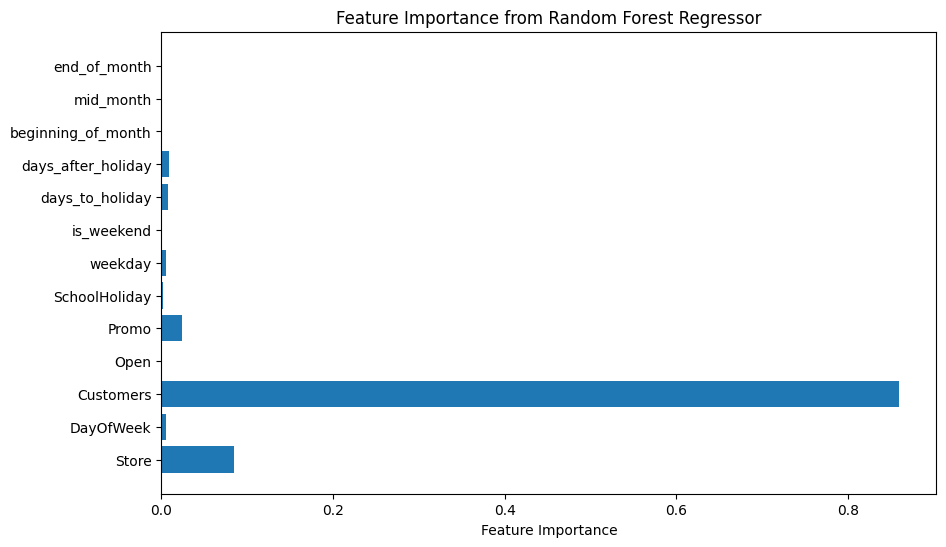

In [6]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model_pipeline.named_steps['regressor'].feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Regressor')
plt.show()

### Model Serialization

In [12]:
import joblib

# Save the model to a file
joblib.dump(model_pipeline, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Building the LSTM Model
In this step, we will build a Long Short-Term Memory (LSTM) model to predict future sales based on historical data. LSTM is a type of Recurrent Neural Network (RNN) that is particularly well-suited for time series forecasting due to its ability to remember long-term dependencies.

### prepare the data

In [7]:
import numpy as np

# Create a function to convert the time series data into a supervised learning format
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Select the relevant features for LSTM
lstm_features = data[['Sales']].values  # Use the 'Sales' column for LSTM
time_step = 10  # Number of previous time steps to use for prediction
X, y = create_dataset(lstm_features, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


### Define the LSTM Model

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the data (assuming X and y are already defined from previous steps)
# Reshape input to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))  # Ensure X is 3D for LSTM

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))  # First LSTM layer
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(50, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))  # Another Dropout layer
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

2025-01-07 05:47:52.548251: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-07 05:47:52.548281: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-07 05:47:52.548289: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-07 05:47:52.548377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-07 05:47:52.548743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Trian the model

In [12]:
# Fit the model
model.fit(X, y, epochs=5, batch_size=32)

Epoch 1/5
31788/31788 [==============================] - 487s 15ms/step - loss: 0.2701
Epoch 2/5
31788/31788 [==============================] - 489s 15ms/step - loss: 0.2658
Epoch 3/5
31788/31788 [==============================] - 485s 15ms/step - loss: 0.2621
Epoch 4/5
31788/31788 [==============================] - 511s 16ms/step - loss: 0.2592
Epoch 5/5
31788/31788 [==============================] - 505s 16ms/step - loss: 0.2567


### Model Serialization

In [14]:
import joblib
joblib.dump(model, 'lstm_model.pkl')

['lstm_model.pkl']

### Check if the model file exists

In [2]:
import joblib
import os

# Define the path to your model file
model_path = "../notebooks/random_forest_model.pkl"

# Ensure the file exists
if os.path.exists(model_path):
    try:
        # Try to load the model
        model = joblib.load(model_path)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
else:
    print(f"Model file not found at {model_path}")

Model loaded successfully!


### Test the Model:

In [4]:
# Example test data with 13 features (replace with actual data)
test_data = [[0.5, 1.2, 3.4, 2.3, 1.0, 0.9, 1.5, 2.6, 1.8, 0.7, 3.1, 4.2, 1.3]]  # Replace with actual values

try:
    prediction = model.predict(test_data)
    print("Prediction:", prediction)
except Exception as e:
    print(f"Error making prediction: {e}")

Prediction: [3.62433908]


/opt/miniconda3/envs/tf1/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Re-save the model with the current version of joblib

In [5]:
# Re-save the model with the current joblib version
new_model_path = "../notebooks/random_forest_model.pkl"
try:
    joblib.dump(model, new_model_path)
    print(f"Model re-saved at {new_model_path}.")
except Exception as e:
    print(f"Error re-saving model: {e}")

Model re-saved at ../notebooks/random_forest_model.pkl.


### Model Evaluation

In [27]:
from sklearn.preprocessing import LabelEncoder

def calculate_accuracy_level(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if mape < 10:
        accuracy_level = "Excellent"
    elif mape < 20:
        accuracy_level = "Good"
    elif mape < 30:
        accuracy_level = "Fair"
    else:
        accuracy_level = "Poor"
    
    return mape, accuracy_level

# Convert categorical columns to strings first to avoid mixed data types
label_cols = ['StateHoliday', 'Promo']  # Add other categorical columns if necessary

# Ensure that all values in these columns are strings
for col in label_cols:
    train_data[col] = train_data[col].astype(str)

# Apply Label Encoding to each categorical column
label_encoder = LabelEncoder()
for col in label_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# Prepare the features (X) and target (y)
X = train_data.drop(columns=['Sales', 'Date'])  # Drop 'Sales' (target) and 'Date' (irrelevant columns)
y = train_data['Sales']  # Target variable is 'Sales'

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model's performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Calculate MAPE and accuracy level using y_val_pred as predictions
mape, accuracy_level = calculate_accuracy_level(y_val, y_val_pred)

print(f'MAPE: {mape:.2f}%')
print(f'Accuracy Level: {accuracy_level}')

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

MAPE: 6.46%
Accuracy Level: Excellent
Mean Absolute Error: 365.7249081113508
Mean Squared Error: 403971.3809122513
R^2 Score: 0.972683957759898
